# Chapter 05 : 릿지 회귀 모델
## 사전 지식
### BFGS, SAG 계열 최적화 알고리즘
경사 하강법 구분
- 기본 경사 하강법 : 최대하강법(steepest descent), 뉴턴법(Newton's method)
- QNM : BFGS, L-BFGS, L-BFGS-G
- 기타 : 컬레기울기법(conjugate gradiant method), 좌표 하강법(coordinate descent)

#### BFGS
BFGS 알고리즘(Broyden-Fletcher-Goldfarb-Shanno)  
- QNM에 속하는 최적화 알고리즘
- 비제약 비선형 최적화 문제(unconstrained nonlinear optimization problem)를 푸는 이터레이션 기반 방법
- 비용 함수의 2계 도함수(second derivative)인 헤시안 행렬(Hessian matrix)과 그 역행렬을 근사한 후 이를 사용하여 파라미터를 업데이트
- scipy.optimize.minimize() 함수로 구현

#### L-BFGS
L-BFGS or LM-BFGS 알고리즘(limited-memory BFGS)
- BFGS 알고리즘이 제한된 양의 컴퓨터 메모리를 사용할 수 있게끔 변형하고 근사한 것
- sklearn 패키지에서는 해당 알고리즘을 사용하지 않음
- sklearn 문서에서 'lbfgs'를 언급한 경우에 L-BFGS-B 알고리즘으로 구현했음을 의미

#### L-BFGS-B
L-BFGS-B 알고리즘(L-BFGS algorithm for bound constrained optimization)
- L-BFGS 알고리즘을 확장한 것
- scipy.optimize.minimize() 함수로 구현
- sklearn 패키지에서 scipy.optimize.minimize() 함수를 호출하여 사용
- solver 하이퍼파라미터의 값을 'lbfgs'로 설정하면 해당 알고리즘 호출
  
BFGS 계열 알고리즘
- 상대적으로 작은 크기의 데이터셋에서 잘 동작  
- 데이터의 크기가 크면 성능이 떨어질 수 있음  

#### SAG
SAG 알고리즘(stochastic average gradient descent)
- 특정한 조건을 만족하는 여러 컨벡스 함수(convex function)의 유한 합을 최적화 하는 기법
- SAG 알고리즘을 사용하는 모델에는 모두 random_state 하이퍼파라미터가 있음

#### SAGA
SAGA 알고리즘
- SAG 알고리즘에서 편향(bias)을 없애고 보완한 변형 알고리즘
  
SAG 계열 알고리즘
- 샘플과 피처의 수가 모두 클 때 다른 최적화 알고리즘보다 빠르게 수렴하는 경향
- 피처 스케일(scale)이 비슷해야만 빠른 수렴이 보장된다는 점에 조심
- 피처 스케일의 전처리를 먼저 수행하는 것이 좋음
- sklearn.preprocessing 모듈의 다양한 피처 스케일링 관련 클래스 사용
- solver 하이퍼파라미터의 값을 각각 'sag', 'saga'로 설정하여 호출

## 1. 릿지 회귀 모델이란?
릿지 회귀(ridge regression)
- OLS의 비용 함수에 파라미터 크기에 대한 L2 페널티(penalty)를 추가하여 비용 함수를 정의한 후 이를 최적화하여 얻는 모델
- L2 규제가 있는 선형 최소 제곱법, 티호노프(Tikhonov) 규제 기법 등으로 불림  
  
릿지 회귀 모델의 비용 함수  
$J_{Ridge}(w) = \parallel y - Xw \parallel_2^2 + \alpha \parallel w \parallel_2^2$
- $\alpha$ : 페널티의 크기를 제어하는 하이퍼파라미터
- $\alpha$가 클수록 감쇄(shrinkage)의 크기가 커짐, 파라미터의 값은 다중공선성(multicollinearity)에 강건(robust)해짐
- 라쏘와 비교해 전반적으로 파라미터 대부분이 모두 점진적으로 감쇄하는 경향

## 2. 릿지 회귀 모델 구현하기
### 릿지 회귀 모델의 기본 이론
릿지 회귀의 비용 함수 $J_{Ridge}(w)$를 전개  
규제 페널티 항 $\alpha \parallel w \parallel_2^2$이 미분 가능 $\rightarrow$ 해를 구하는 과정이 간단  
$\qquad J_{Ridge}(w) = \parallel y - Xw \parallel_2^2 + \alpha \parallel w \parallel_2^2 = (y - Xw)^T(y - Xw) + \alpha w^Tw$  
  
오른쪽 식을 $w$에 대해 미분 $\rightarrow$ $J_{Ridge}(w)$의 기울기가 0이 되는 지점 찾기  
$\qquad \nabla J_{Ridge}(w) = 0$ $\rightarrow$ $-2X^Ty + 2X^TXw + 2\alpha w = 0$  
  
행렬 $X^TX + \alpha I$ : 양의 정부호 행렬(positive definite matrix) $\rightarrow$ 항상 역행렬이 있음  
$\qquad$ 유일 해 $\hat{w}_{Ridge} = (X^TX + \alpha I)^{-1}X^Ty$  ($I$ : 항등 행렬)
  
얻은 해가 $J_{Ridge}(w)$를 최소화하는 해라는 것 보이기 $\rightarrow$ $J_{Ridge}(w)$의 헤시안(Hessian)이 양의 정부호 행렬임을 확인  
헤시안 H : $J_{Ridge}(w)$의 2계 도함수(second derivative)  
$\qquad H = 2X^TX + 2\alpha I$  
  
$\frac{1}{2}H = X^TX + \alpha I$가 양의 정부호 행렬임을 보이는 것과 동일  
$\qquad z^T(X^TX + \alpha I)z = z^TX^TXz + \alpha z^Tz = \parallel Xz \parallel_2^2 + \alpha \parallel z \parallel_2^2 > 0$  (0이 아닌 벡터 $z \in \mathbb{R}^p$)  
  
$\rightarrow$ 헤시안이 대칭 양의 정부호 행렬 $\rightarrow$ $\hat{w}_{Ridge}$ : $J_{Ridge}(w)$를 최소화하는 해  
  
릿지 회귀도 X의 특잇값 분해(SVD)를 이용한 방식으로 수행 가능  
- X가 특이 행렬(singular matrix)에 가까울수록 사용 효과가 큼  
- $\sigma_i$ : i번째 특잇값(singular value)  
  
$\hat{w}_{Ridge} = \displaystyle\sum_{i = 1}^{p} \frac{\sigma_i^2}{\sigma_i^2 + \alpha^2} \frac{u_i^Ty}{\sigma_i} v_i$

#### 시간 복잡도
- OLS와 동일한 수준인 $O(np^2)$

### 릿지 회귀 모델의 심화 이론
#### TSVD-OLS와 릿지 회귀의 유사성
- OLS의 해의 과적합성을 줄인하는 측면 $\rightarrow$ 릿지 회귀 & TSVD-OLS 비숫
  
축약 SVD(reduced SVD) 적용한 OLS의 해  
$\hat{s}_{OLS} = V\sum_{R}^{-1} y = \displaystyle\sum_{i = 1}^{p} \frac{u_i^Ty}{\sigma_i}v_i$  
  
TSVD-OLS : OLS의 해에서 특정 임계값 이하의 특잇값을 제외하여 피처를 근사한 후에 계산  
$\hat{w}_{TSVD-OLS} = \displaystyle\sum_{i = 1}^{k} \frac{u_i^Ty}{\sigma_i}v_i$  
  
릿지 외귀 : 규제 하이퍼파라미터의 값이 $\alpha$일 때  
$\hat{w}_{Ridge} = \displaystyle\sum_{i = 1}^{p} \frac{\sigma_i^2}{\sigma_i^2 + \alpha^2} \frac{u_i^Ty}{\sigma_i}v_i$  
  
3개의 식에 공통 표현 존재 $\rightarrow$ 계수 $\psi_i$ 도입  
$\hat{w} = \displaystyle\sum_{i = 1}^{k} \psi_i \frac{u_i^Ty}{\sigma_i}v_i$  
  
   
- OLS : 모든 $i$에 대하여 $\psi_i = 1$로 두어 규제(regularization)를 별도로 적용하지 않음
- TSVD-OLS : 특잇값의 개수$k$를 기준으로 그 이하의 값은 $\psi_i$를 1로, 이후의 값은 0으로 두어 계단형 점프(sharp jump) 형태의 규제를 적용
- 릿지 회귀 : 일부의 하이퍼파라미터를 선택적으로 삭제하는 대신 각각의 파라미터의 값을 감쇄  
$\psi_ㅑ = \frac{\sigma_i^2}{\sigma_i^2 + \alpha^2}$

### 릿지 회귀 모델 구현하기
- 정규 방정식 풀이 방식 $\alpha$가 0, 0.1, 1인 릿지 회귀 모델을 각각 구현

In [7]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y = True, as_frame = False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1234)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

n_train, n_test = X_train.shape[0], X_test.shape[0]

X_train = np.append(np.ones((n_train, 1)), X_train, axis = 1)
X_test = np.append(np.ones((n_test, 1)), X_test, axis = 1)

$\hat{w}_{Ridge} = (X^TX + \alpha I)^{-1}X^Ty$

- 계산한 $\hat{w}_{Ridge}$ 값을 학습 데이터셋과 테스트 데이터셋에 각각 대입
- alpha 값에 따른 평균 절대 오차(MAE) 계산

In [8]:
alphas = [0, 0.1, 1]

for alpha in alphas:
    w = np.linalg.inv(X_train.T @ X_train + alpha * np.identity(X_train.shape[1])) @ X_train.T @ y_train
    
    y_train_pred = X_train @ w
    print(f'alpha 값이 {alpha}일 때')
    print(f'학습 데이터셋 MAE : {np.abs(y_train_pred - y_train).mean() : .3f}')
    
    y_pred = X_test @ w
    print(f'테스트 데이터셋 MAE : {np.abs(y_pred - y_test).mean() : .3f}')

alpha 값이 0일 때
학습 데이터셋 MAE :  43.549
테스트 데이터셋 MAE :  42.618
alpha 값이 0.1일 때
학습 데이터셋 MAE :  43.924
테스트 데이터셋 MAE :  43.368
alpha 값이 1일 때
학습 데이터셋 MAE :  48.909
테스트 데이터셋 MAE :  49.590


## 패키지로 표현하기
sklearn.linear_model.Ridge 클래스 : 릿지 회귀 모델 구현  
Ridge 클래스 하이퍼파라미터  
- alpha
    - 주요값 : float >= 0
    - 기본값 : 1.0
    - 의미 : 규제 강도를 뜻함 (alpha가 클수록 규제가 크게 작용)
- fit_intercept
    - 주요값 : Bool
    - 기본값 : True
    - 의미 : 절편 포함 여부 결정
        - True : 절편 포함
- max_iter
    - 주요값 : int > 0
    - 기본값 : None
    - 의미 : 이터레이션 횟수의 상한선
        - None : solver에 따라 다른 기본값 부여
- tol
    - 주요값 : float > 0
    - 기본값 : 1e-3
    - 의미 : 해의 정밀성(precision), 해를 얼마나 정밀하게 구할 것인지 결정
- solver
    - 주요값 : 'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'
    - 기본값 : 'auto'
    - 의미 : 최적화 기법 선택
        - 'auto' : 데이터에 따라 이하 옵션 중 자동 선택
        - 'svd' : X에 SVD를 적용한 수 파라미터를 추정
                  피처가 특이 행렬에 가까우면 'cholesky'에 비해 더 안정적인 결과를 도출함
        - 'cholesky' : 앞의 이론과 구현 부분에서 사용한 기법
                       scipy.linalg.solve() 함수를 사용 = 숄레스키 분해(Cholesky decomposition)를 통해 역행렬을 구한 후 닫힌 형태의 해를 구하는 것
        - 'lsqr' : scipy.sparse.linalg.lsqr() 함수로 구현한 최소 제곱법 사용
                   희소 행렬에 적용하면 속도가 매우 빠름
                   이터레이션(iteration) 기반으로 수행
        - 'sparse_cg' : scipy.sparse.linalg.cg() 함수로 구현한 켤레기울기법(conjugate gradient method) 사용
                        대형 데이터셋에서는 'cholesky'보다 더 적합
        - 'sag' : SAG 알고리즘
        - 'saga' : SAGA 알고리즘
        - 'lbfgs' : L-BFGS-B 알고리즘
- positive
    - 주요값 : bool
    - 기본값 : False
    - 의미 : True라면 파라미터가 모두 양수값을 가지도록 강제함 ('lbfgs' solver에서만 사용 가능)
- random_state
    - 주요값 : None, int
    - 기본값 : None
    - 의미 : solver가 'sag' 또는 'saga'라면 데이터를 무작위로 섞는데, 이때의 무작위성을 고정

#### 실제 사용 시 활용 팁
- 특정 피처 범위로 말미암아 비용 함수가 큰 영향을 받는 것을 피하려면 피처 스케일링을 먼저 수행해야 함
- 릿지 회귀에서도 규제 페널티 $\alpha$값은 모든 파라미터의 크기와 모델 성능에 큰 영향을 끼침  
$\rightarrow$ 적절한 $\alpha$값을 선택하는 것이 중요
    - 검증 데이터로 다양한 $\alpha$값을 테스트한 후 최적의 $\alpha$값을 선택
    - sklearn.linear_model.RidgeCV 클래스를 이용하여 교차검증법(cross validation)으로 결정
- RidgeCV 클래스로 LOOCV(leave-one-out cross-validation), K-fold 교차검증법 등 적용할 교차검증법을 선택, $\alpha$값 후보와 클래스 가중치 등을 설정
    - LOOCV : 테스트 데이터셋의 샘플 개수를 하나로 하는 가장 극단적인 형태의 교차검증법
    
#### Ridge 클래스 사용하기
- 정규 방정식을 이용한 직접 구현과 Ridge 클래스의 결과를 비교

In [9]:
from sklearn.linear_model import Ridge
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np

X, y = load_diabetes(return_X_y = True, as_frame = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1234)

- alpha가 0, 0.1, 1일 때 각각의 릿지 회귀 모델을 학습하고 학습 데이터셋과 테스트 데이터셋의 평균 절대 오차(MAE)를 비교

In [12]:
alphas = [0, 0.1, 1]

for alpha in alphas:
    reg = Ridge(alpha = alpha)
    reg = reg.fit(X_train, y_train)
    
    y_pred_train = reg.predict(X_train)
    print(f'alpha 값이 {alpha}일 때')
    print(f'학습 데이터셋 MAE : {np.abs(y_pred_train - y_train).mean() : .3f}')
    
    y_pred = reg.predict(X_test)
    print(f'테스트 데이터셋 MAE : {np.abs(y_pred - y_test).mean() : .3f}')
    print()

alpha 값이 0일 때
학습 데이터셋 MAE :  43.549
테스트 데이터셋 MAE :  42.618

alpha 값이 0.1일 때
학습 데이터셋 MAE :  43.928
테스트 데이터셋 MAE :  43.366

alpha 값이 1일 때
학습 데이터셋 MAE :  48.966
테스트 데이터셋 MAE :  49.582



#### OLS와 릿지 회귀의 변동성
- 학습 데이터셋의 샘플 개수가 적다면 피처의 노이즈가 학습한 모델 파라미터의 변동성에 큰 영향을 주는 OLS 모델과 달리 릿지 회귀 모델은 규제를 통해 파라미터의 크기를 감쇄시켜 변동성을 줄임
- 노이즈의 효과를 명확하게 관찰하고자 두 건의 샘플로 학습 데이터를 구성하며 피처도 1차원이 되도록 함

In [14]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt
%matplotlib inline

X_train = np.array([[0.5], [1]])
y_train = np.array([0.5, 1])
X_test = np.array([[0], [2]])

- OLS일 때의 원본 데이터 기울기 예측값(파란색 선)과 노이즈를 포함한 데이터 기울기의 예측값(회색)을 나타냄
- 노이즈 : 원 데이터에 가우시안 에러를 더하여 생성
- 붉은 점 : 원본 학습 데이터
- 회색 점 : 노이즈를 포함한 학습 데이터

Text(0, 0.5, 'y')

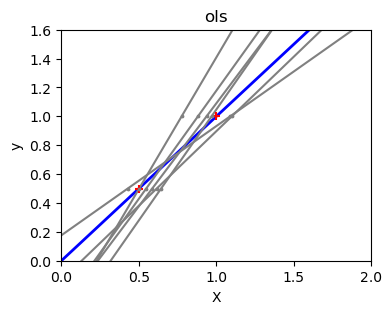

In [15]:
np.random.seed(1234)

fig, ax = plt.subplots(figsize = (4, 3))

clf = LinearRegression().fit(X_train, y_train)
ax.plot(X_test, clf.predict(X_test), linewidth = 2, color = "blue")
ax.scatter(X_train, y_train, s = 30, c = "red", marker = "+", zorder = 10)

for _ in range(6):
    this_X = 0.1 * np.random.normal(size = (2, 1)) + X_train
    clf = LinearRegression().fit(this_X, y_train)
    ax.plot(X_test, clf.predict(X_test), color = "gray")
    ax.scatter(this_X, y_train, s = 3, c = "gray", marker = "o", zorder = 10)
    
ax.set_title('ols')
ax.set_xlim(0, 2)
ax.set_ylim((0, 1.6))
ax.set_xlabel("X")
ax.set_ylabel("y")

- 릿지 회귀 모델을 학습하고 결과를 그래프로 나타냄

Text(0, 0.5, 'y')

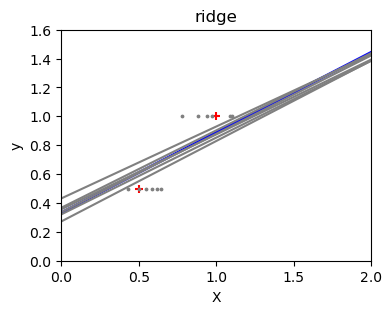

In [19]:
np.random.seed(1234)

fig, ax = plt.subplots(figsize = (4, 3))

clf = Ridge(alpha = 0.1).fit(X_train, y_train)
ax.plot(X_test, clf.predict(X_test), linewidth = 2, color = "blue")
ax.scatter(X_train, y_train, s = 30, c = "red", marker = "+", zorder = 10)

for _ in range(6):
    this_X = 0.1 * np.random.normal(size = (2, 1)) + X_train
    clf = Ridge(alpha = 0.1).fit(this_X, y_train)
    ax.plot(X_test, clf.predict(X_test), color = "gray")
    ax.scatter(this_X, y_train, s = 3, c = "gray", marker = "o", zorder = 10)
    
ax.set_title('ridge')
ax.set_xlim(0, 2)
ax.set_ylim((0, 1.6))
ax.set_xlabel("X")
ax.set_ylabel("y")

- 노이즈가 달라지더라도 파리미터의 값(기울기)은 크게 변하지 않음
- 릿지 회귀 모델은 노이즈에 강건(robust)
- 붉은 점과 회색 점 모두 그래프와 겹치지 않음 = 릿지 회귀 모델 편향성(bias)을 지니게 설정되었다는 것을 뜻함
- 릿지 회귀 모델은 OLS 회귀 모델에 비해 분산은 줄지만 편향성은 증가하는 효과 있음

## 4. 릿지 회귀 모델 보충 수업
### 편향-분산 상충 관계와 릿지 회귀의 분산
- 추정할 파라미터 $\theta$에 대한 추정량(estimator) $\hat{\theta}$의 품질(quality)을 평가하려면 평균 제곱 오차(MAE)의 편향-분산 분해(bias-variance decomposition)를 사용하는 것이 일반적  
$MSE = E[(\hat{\theta} - \theta)^2] = E[\hat{\theta^2}] - 2\theta E[\hat{\theta}] + \theta^2$  
  
분산 $Var(\hat{\theta}) = E[(\theta - E[\theta])^2] = E[\theta^2] - (E[\hat{\theta}])^2$  
편향의 제곱 $Bias(\hat{\theta})^2 = (E[\theta] - \theta)^2 = (E[\theta])^2 - 2\theta E[\hat{\theta}] + \theta^2$  
  
$\rightarrow$ $MSE = Var(\hat{\theta}) + Bias(\theta)^2$
- 편향-분산 상충 관계(bias-variance trade-off)
- 불편추정량(unbiased estimator)은 평균 제곱 오차(MSE)와 분산이 같음 $\rightarrow$ MSE를 최소화하려면 분산을 최소화
- 샘플이 커짐에 따라 특정 조건에서 최대 가능도 추정량(MLE)은 불편추정량이자 최소 분산 추정량으로 수렴
- 대부분의 경우 MLE가 최고의 추정량
- 어떤 경우 편향 추정량(biased estimator)이 MLE보다 더 유용할 수도 있음  
  
릿지 추정량의 분산이 OLS 추정량의 분산보다 작음 $\rightarrow$ 학습 모델의 일반화 가능성 측면에서 릿지 추정량의 이점이 있음  
통계 모델 관점에서 보면 릿지 추정량(ridge esimator)은 OLS 추정량과 달리 편향 추정량이고, 실제 데이터가 선형에 매우 가까우면 릿지 회귀 모델을 사용하는 것이 오히려 안 좋을 수 있음  

#### 거의 완벽한 선형 데이터에서의 OLS 모델과 릿지 회귀 모델
- 거의 완벽하게 선형성을 따르는 데이터에서 OLS 모델과 릿지 회귀 모델을 학습하고 결과를 비교
- 노이즈는 일부만 부과
- 분산을 나타내는 v를 매우 작은 값인 0.01로 설정 $\rightarrow$ 데이터셋이 거의 완벽한 선형성을 따르도록 함
- 랜덤성을 제어하고자 피처를 생성하기 직전에 np.random.seed(1234) 함수를 실행

In [20]:
import numpy as np
import pandas as pd

n, n_train = 1000, 700
m, v = 1, 0.01

np.random.seed(1234)

X1 = np.random.normal(m, v, size = n)
X2 = np.random.normal(m, v, size = n)
X3 = np.random.normal(m, v, size = n)
X4 = np.random.normal(m, v, size = n)
y = X1 * 100 + X2 * 10 + X3 * 30 + X4 * 50 + np.random.normal(m, v, size = n)
df = pd.DataFrame({'y' : y, 'X1' : X1, 'X2' : X2, 'X3' : X3, 'X4' : X4})

train, test = df.iloc[:n_train, :], df.iloc[n_train:, :]

X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]

In [21]:
from sklearn.linear_model import LinearRegression, Ridge

reg1 = LinearRegression()
y_pred = reg1.fit(X_train, y_train).predict(X_test)

print(f'OLS 모델의 MAE : {((y_pred - y_test)**2).mean() : .5f}')

OLS 모델의 MAE :  0.00011


- 규제의 강도를 나타내는 하이퍼파라미터 alpha를 1000에서 1/10씩 줄이며 테스트 데이터셋을 기준으로 MAE를 구함

In [22]:
for alpha in [1000, 100, 10, 1, 0.1, 0.01, 0.001]:
    reg2 = Ridge(alpha = alpha)
    y_pred = reg2.fit(X_train, y_train).predict(X_test)
    
    print(f'alpha 값이 {alpha}일 때 릿지 회귀 모델의 MAE : {((y_pred - y_test)**2).mean() : .5f}')

alpha 값이 1000일 때 릿지 회귀 모델의 MAE :  1.40489
alpha 값이 100일 때 릿지 회귀 모델의 MAE :  1.40325
alpha 값이 10일 때 릿지 회귀 모델의 MAE :  1.38701
alpha 값이 1일 때 릿지 회귀 모델의 MAE :  1.23913
alpha 값이 0.1일 때 릿지 회귀 모델의 MAE :  0.51807
alpha 값이 0.01일 때 릿지 회귀 모델의 MAE :  0.02526
alpha 값이 0.001일 때 릿지 회귀 모델의 MAE :  0.00040


- alpha가 0에 가까울수록 MAE는 단조 감소하며 OLS의 MAE에 접근
- alpha값이 작을수록 좋은 성능을 냄 $\rightarrow$ 해당 데이터셋에서는 릿지 회귀 모델을 사용하는 것이 부적절하다는 것을 뜻함
- 데이터의 선형성이 매우 높으면 릿지 회귀 모델은 OLS 모델보다 성능이 떨어질 수 있음

### 릿지 분류 모델
릿지 분류(ridge classification) 모델 : 릿지 회귀 모델을 변형한 것  
- 이진 목푯값을 각각 -1과 1로 변형하고 문제를 릿지 회귀 모델로 해결
- 학습 후 예측값의 부호를 예측 클래스에 대응하여 분류를 수행
- 색다른 선택지를 주면서 동시에 빠르기도 함 $\rightarrow$ 유용하게 사용 가능
  
sklearn.linear_model.RidgeClassifier 클래스로 구현
- RidgeClassifier의 학습 속도는 로지스틱 회귀 모델에 비해 매우 빠름
- 로지스틱 회귀 모델 구현 sklearn.linear_model.LogisticRegression 클래스 : 이터레이션 기반
- RidgeClassifier : $(X^TX)^{-1}X^T$ 계산 한 번만 수행하면 됨

### 엘라스틱 넷 회귀 모델

엘라스틱 넷 회귀 모델 : L1 규제와 L2 규제를 동시에 적용하는 선형 회귀 모델
- 라쏘의 일부 피처 선택 특성과 릿지 회귀의 전반적인 피처 크기 감쇄 특성이 모두 존재  
$J_{Elastic net}(w) = \frac{1}{2n} \parallel y _ Xw \parallel^2 + \alpha\rho \parallel w \parallel_1 + \frac{\alpha(1 - \rho)}{2} \parallel w \parallel_2^2$  
    - $\alpha$ : 전체 규제의 강도를 제어
    - $\rho$ : L1와 L2 규제 사이의 비율을 제어
- 높은 상관성이 있는 여러 개의 피처를 모두 사용하고 싶을 때 유용
  
sklearn.linear_model.ElasticNet 클래스 : 엘라스틱 넷 회귀 모델 구현  
- L1 규제에 해당하는 부분을 미분할 수 없으므로 좌표 하강법(coordinate descent)으로 구현
- 많은 하이퍼파라미터를 라쏘와 공유 ($\alpha$, fit_intercept, max_iter, tol, positive, selection, random_state 등)
- rho 하이퍼파라미터가 비용 함수에서 $\rho$에 대한 부분으로 추가됨
- 교차검증법 수행 : sklearn.linear_model.ElasticNetCV 클래스

### 5장 되새김 문제
#### 1. Ridge 클래스 적용하기
- 당뇨병 데이터셋과 Ridge 클래스를 이용하여 릿지 회귀 모델을 학습하고 성능을 평가

In [24]:
from sklearn.linear_model import Ridge
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

X, y = load_diabetes(return_X_y = True, as_frame = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1234)

1. 최소-최대 스케일러(min-max scaler)로 학습 데이터의 피처를 스케일링하라. 같은 기준으로 테스트 데이터셋의 피처 또한 스케일링한다.
2. 학습 데이터셋으로 릿지 회귀 모델을 학습하라. 이때 규제 하이퍼파리미터 $\alpha$는 10으로 하고, 최적화 알고리즘은 SAG로 한다. 결과의 재현성을 위해 random_state는 1234로 설정한다.
3. 학습한 모델을 테스트 데이터의 전처리된 피처에 적용하여 예측값을 구한다.

- 예측값과 실제값을 비교하여 평균 제곱근 오차(RMSE)를 계산하라.

In [29]:
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

reg = Ridge(alpha = 10, solver = 'sag', random_state = 1234)
y_pred = reg.fit(X_train_scaled, y_train).predict(X_test_scaled)

print(f'RMSE : {np.sqrt(((y_pred - y_test)**2).mean()) : .3f}')

RMSE :  56.232


#### 비선형 회귀 문제에서의 선형 규제 모델
- 피처는 네 개를 사용하며 무작위 샘플을 작은 노이즈와 함께 생성한 후 우선 목표 변수가 피처와 양의 관계를 따르도록 생성
- 다시 무작위로 샘플을 생성한 후 목표 변수가 피처와 음의 관계를 따르도록 생성
- 데이터를 결합하여 통합 데이터셋을 형성  
$\rightarrow$ 각각의 절반은 높은 선형 관계를 보이지만 합쳐진 데이터셋에서는 더이상은 선형 관계가 나타나지 않음  
- 패턴 번호를 나타내는 X5 변수를 생성하여 패턴에 따라 달라지는 앙상까지 데이터셋에 표현

In [30]:
import numpy as np
import pandas as pd

n1, n2, n_train = 2500, 2500, 4000
m, v = 1, 0.1

np.random.seed(1234)

X1 = np.random.normal(m, v, size = n1)
X2 = np.random.normal(m, v, size = n1)
X3 = np.random.normal(m, v, size = n1)
X4 = np.random.normal(m, v, size = n1)
y = X1 * 200 + X2 * 30 + X3 * 100 + X4 * 500
df1 = pd.DataFrame({'y'  :y, 'X1' : X1, 'X2' : X2, 'X3' : X3, 'X4' : X4})
df1['X5'] = 0

X1 = np.random.normal(m, v, size = n2)
X2 = np.random.normal(m, v, size = n2)
X3 = np.random.normal(m, v, size = n2)
X4 = np.random.normal(m, v, size = n2)
y = -X1 * 500 - X2 * 300 - X3 * 200 -X4 * 100
df2 = pd.DataFrame({'y' : y, 'X1' : X1, 'X2' : X2, 'X3' : X3, 'X4' : X4})
df2['X5'] = 1

df = pd.concat([df1, df2])
df = df.sample(frac = 1, random_state = 1234)
df

,y,X1,X2,X3,X4,X5
206,-1043.525008,0.854545,0.980386,1.084388,1.052588,1
2436,783.900028,0.742729,1.102032,0.776963,1.049194,0
1201,909.283251,0.958107,1.159922,1.071176,1.151493,0
1486,832.806098,1.066110,0.975990,0.939312,0.992746,0
1786,-1101.601106,0.940846,1.111162,0.959809,1.058676,1
...,...,...,...,...,...,...
664,842.658338,1.176910,1.054615,1.047532,0.941769,0
776,-1209.189849,1.125480,1.030696,1.174190,1.024031,1
1318,878.704510,1.140897,1.047285,0.954595,1.047294,0
723,877.670564,0.948883,1.220475,1.123088,1.077942,0


- 학습 데이터셋과 테스트 데이터셋을 분할

In [31]:
train, test = df.iloc[:n_train, :], df.iloc[n_train:, :]

X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]

- 데이터셋에 OLS, 라쏘, 릿지 회귀 모델을 각각 적용하여 학습 후 평균 절대 오차(MAE)를 계산

In [32]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

reg1 = LinearRegression()
y_pred = reg1.fit(X_train, y_train).predict(X_test)
print(f'OLS 모델의 MAE : {((y_pred - y_test)**2).mean() : .3f}')

reg2 = Lasso()
y_pred = reg2.fit(X_train, y_train).predict(X_test)
print(f'LASSO 모델의 MAE : {((y_pred - y_test)**2).mean() : .3f}')

reg3 = Ridge()
y_pred = reg3.fit(X_train, y_train).predict(X_test)
print(f'Ridge 모델의 MAE : {((y_pred - y_test)**2).mean() : .3f}')

OLS 모델의 MAE :  2482.060
LASSO 모델의 MAE :  2745.020
Ridge 모델의 MAE :  2483.001


In [34]:
# MAE가 어느 정도의 성능인지 판단
# 랜텀 포레스트 회귀 모델과 비교

from sklearn.ensemble import RandomForestRegressor

reg4 = RandomForestRegressor(random_state = 1234)
y_pred = reg4.fit(X_train, y_train).predict(X_test)
print(f'랜덤 포레스트 회귀 모델의 MAE : {((y_pred - y_test)**2).mean() : .3f}')

랜덤 포레스트 회귀 모델의 MAE :  60.177
